In [5]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
from copy import deepcopy
import pickle
import czifile
import imageio
from skimage.filters.thresholding import threshold_otsu

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi
import notebook_functions_20210504 as nf

I think I need some more datasets:

- More long duration datasets in nc14, probably with eve and sna (leaving hb for the second because of hlb issue).  
- Some 'control' movies with Zelda.
- Bleed-through control (PCP-GFP, MCP-mcherry is a good candidate, as is MCP-mcherry alone).

With what I've got, the Z correction should help. The question still remains of how the protein and MS2 signals are related. I think the present strategy should be to find signals in the data I've got, then verify that they are absent in the control data.

I'm not sure what's up with the long hb datasets. The MS2 traces just look shitty: few bursts, not really coherent. The sna data look much better, but it's just one dataset. I apparently took some longer eve datasets on 4/8, Let me check those out.

In [2]:
eve_em2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210408-Rpb1GFP-eveMS2-zsmv-em2-03-06.pkl')

In [3]:
eve_em3 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210408-Rpb1GFP-eveMS2-zsmv-em3-06-to-10.pkl')

In [6]:
reload(imp)
eve_em2_intvol, eve_em2_intfit, eve_em2_prot = imp.correct_spot_data_depth(eve_em2.spot_data, return_dfs=True)

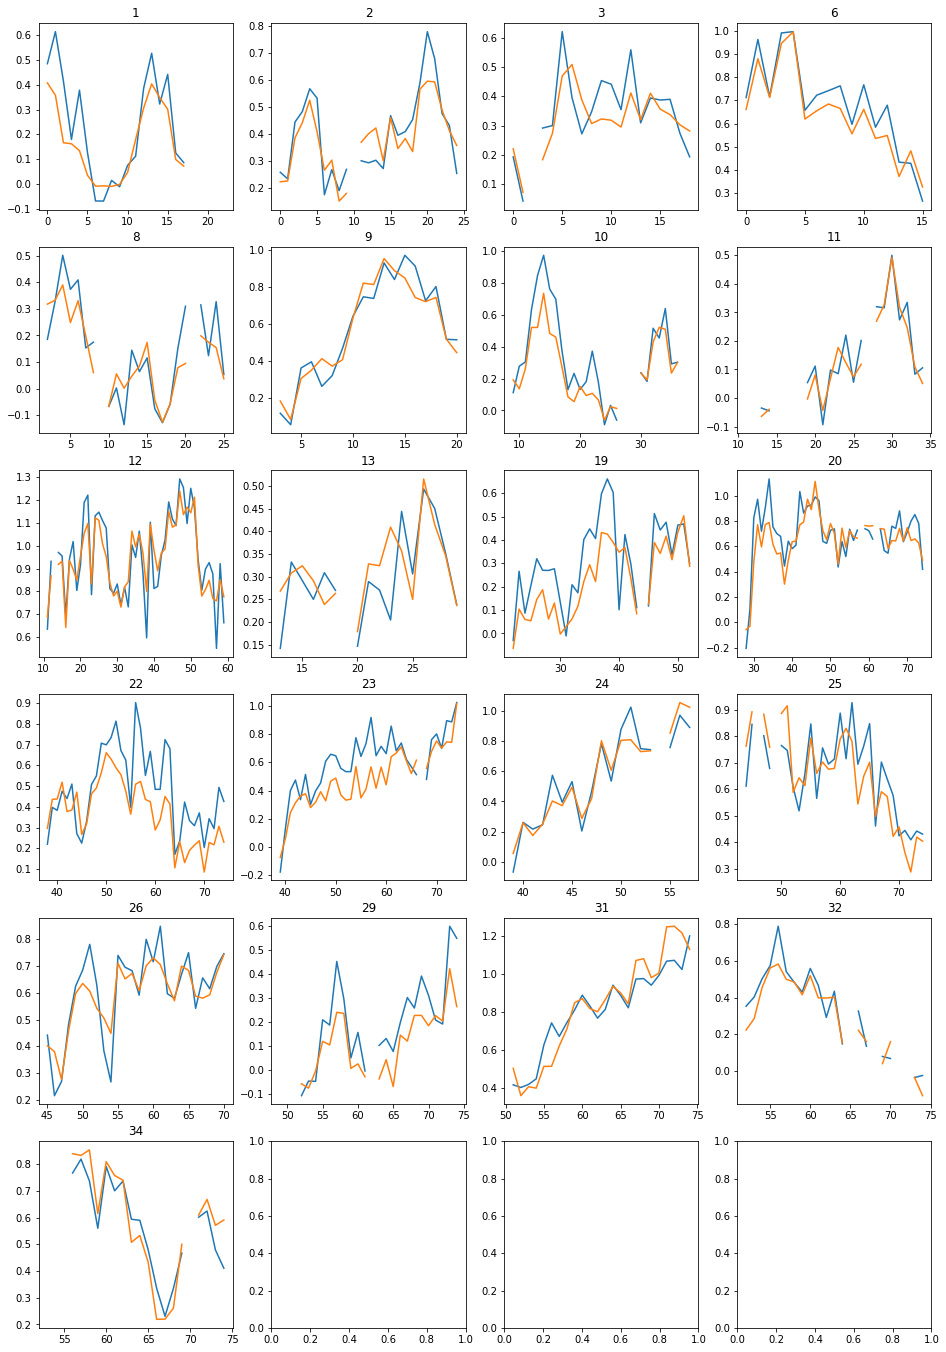

In [10]:
imp.spotdf_plot_traces_bleachcorrect(eve_em2_intvol, eve_em2_intfit, 15, eve_em2.stack[0], sigma=0.1)

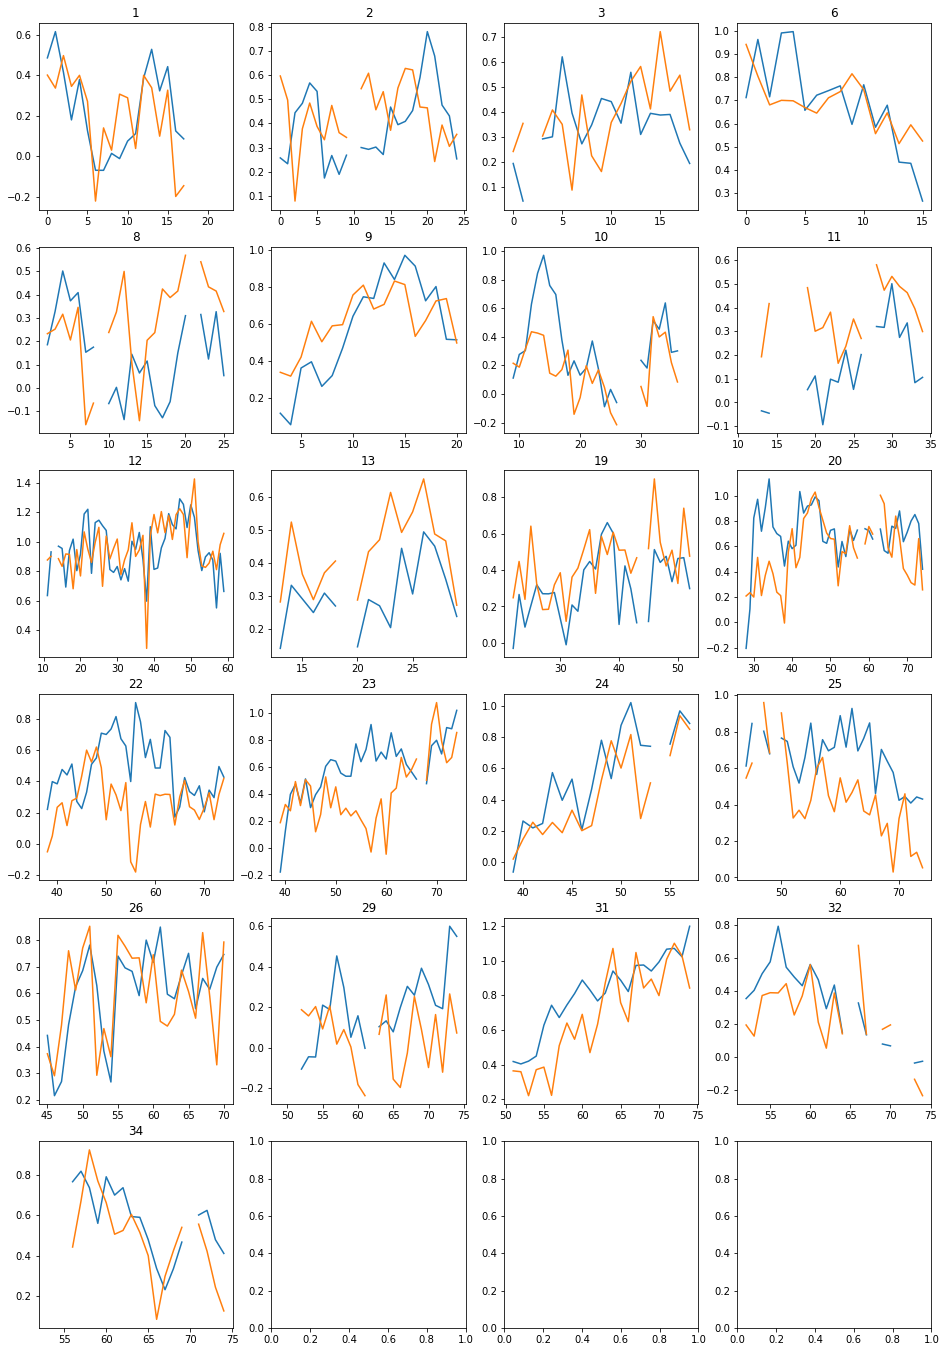

In [16]:
imp.spotdf_plot_traces_bleachcorrect(eve_em2_intvol, eve_em2_prot, 15, eve_em2.stack[0], sigma=0.1)

In [17]:
eve_em3_intvol, eve_em3_intfit, eve_em3_prot = imp.correct_spot_data_depth(eve_em3.spot_data, return_dfs=True)

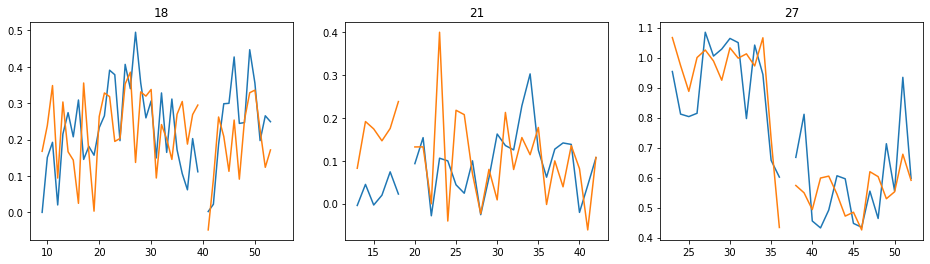

In [20]:
imp.spotdf_plot_traces_bleachcorrect(eve_em3_intvol, eve_em3_prot, 25, eve_em3.stack[0], sigma=0.1)

In [ ]:
eve = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-06.pkl')

OK these two eve datasets suck. I'm not sure why but very few spots that persist for any lenght of time. Maybe it's a z depth problem? I don't remember this being an issue. I'm going to search through all my rpb1-eve datasets and see what I have.

In [30]:
eve = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200915-rpb1-eve-em4-zsmv-01-02.pkl')

In [31]:
viewer(eve.stack, zmax=True)

interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [64]:
#Good
eve1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200811-rpb1-eve-em1-zsmv-06.pkl')
eve2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200811-rpb1-eve-em2-zsmv-04-05.pkl')
eve3 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200915-rpb1-eve-em4-zsmv-01-02.pkl')
eve4 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200915-rpb1-eve-em4-zsmv-04-06.pkl')


What I need to do is combine long trajectories from multiple datasets.

In [65]:
from imagep import spotdf_bleach_correct
def combine(spot_datas, cols=[9,10,11]):
    spot_data_combined = deepcopy(spot_datas[0])
    next_spot_id = np.max(list(spot_data_combined.keys())) + 1
    for i in range(1, len(spot_datas)):
        for j in range(1, len(spot_datas[i]) + 1):
            spot_data_combined[next_spot_id] = spot_datas[i][j]
            next_spot_id += 1
    dfs = []
    
    # Bleach correct
    # Z correct
    # normalize
    for col in cols:
        df = imp.movie.make_spot_table(spot_data_combined, np.zeros(1000), col)
        row_nonzero_counts = df.apply(lambda x: np.count_nonzero(~np.isnan(x)), axis=1)
        last_row = np.max(np.where(row_nonzero_counts > 0))
        df = df.iloc[:(last_row+1),:]
        dfs.append(df)
    return [spot_data_combined] + dfs
    

In [99]:
from imagep import spotdf_bleach_correct, correct_spot_data_depth, add_volume_mean
def combine2(mvs, ij_rad=3, z_rad=1.5, ij_scale=1, z_scale=1, bleach_channel=0, data_channel=0, slope=-338, slice_thickness=0.66):
    def process_mv(mv, ij_rad=3, z_rad=1.5, ij_scale=1, z_scale=1, bleach_channel=0, data_channel=0, slope=-338, slice_thickness=0.66):
        spot_data_newcol = add_volume_mean(mv.spot_data, mv.stack, data_channel, ij_rad, z_rad, ij_scale, z_scale)
        newcol = spot_data_newcol[1].shape[1] - 1
        df_z_corr = correct_spot_data_depth(spot_data_newcol, slope=slope, slice_thickness=slice_thickness, cols=[newcol], return_dfs=True)[0]
        df_z_bleach_corr = spotdf_bleach_correct(df_z_corr, mv.stack[bleach_channel])
        lower, upper = np.nanpercentile(df_z_bleach_corr, [5,95])
        df_z_bleach_corr_norm = (df_z_bleach_corr - lower) / (upper-lower)
        return df_z_bleach_corr_norm
    df = process_mv(mvs[0])
    for mv in mvs[1:]:
        df = pd.concat([df, process_mv(mv)], axis=1)
    return df
        
        
        

In [107]:
a = combine2([eve1, eve2, eve3, eve4], data_channel=1, ij_rad=6)

10 20 30 40 10 20 30 40 50 60 70 80 90 10 20 30 40 50 60 70 80 90 10 20 30 40 50 60 

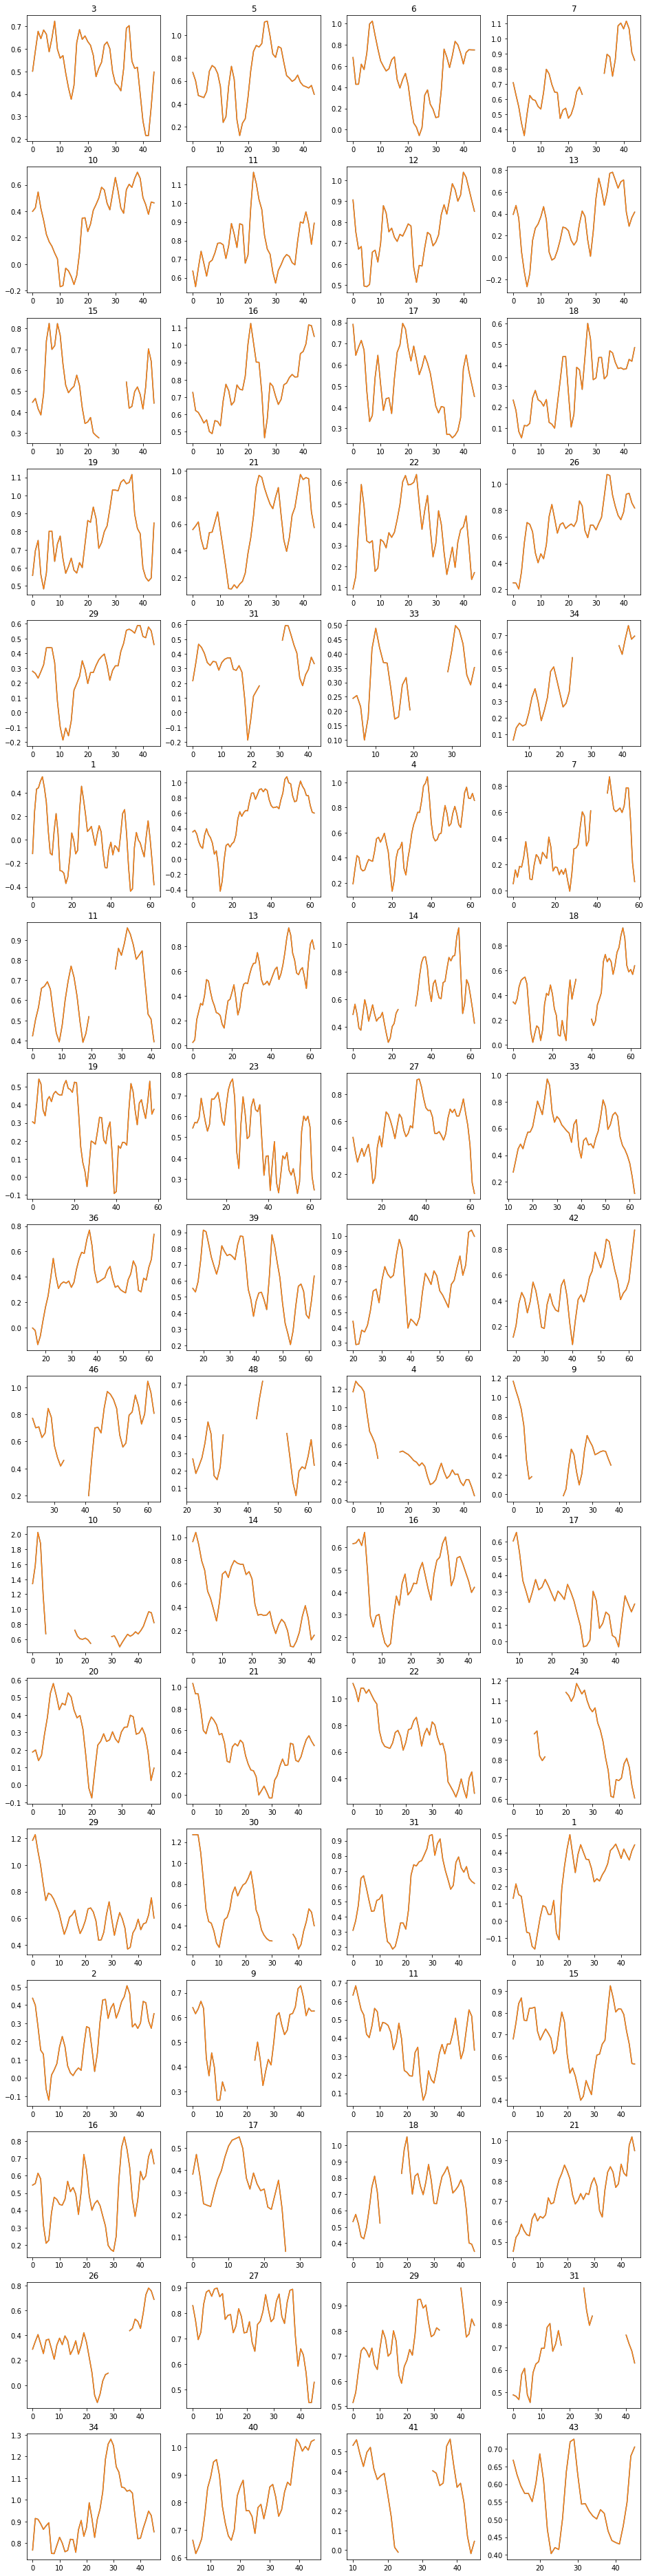

In [109]:
imp.spotdf_plot_traces(a,a, 40, sigma=0.8)

### Focus on eve

I did some comparing to the eve data in Augusto's paper. I think a couple things. First, I need longer duration movies. The interesting features of these movies really come out with longer time frames (20+ minutes but preferably even longer). Second, it's gonna be important to connect spots across "null" frames but using nuclear segmentation. I've never particularly gotten that right, so maybe this is the time. Time to revisit nuclear segmentation with Rpb1.

Gonna try to start a little fresh.

In [146]:
test = eve1.stack[0,40]

In [272]:
from imagep import gradient_nD, peak_local_max_nD, labelmask_filter_objsize, filter_labelmask, object_circularity
from skimage.segmentation import flood_fill, watershed

############################################################################
def segment_nuclei_3Dstack_rpb1_(stack, seed_window=(15,50,50), 
    min_seed_dist=25, size_min=0, size_max=50000, circularity_min=0.3, 
    sigma=5):
    """Segment nuclei from Rpb1 fluorescence in confocal data.
    
    Algorithm is smooth -> threshold -> distance transform to find seeds ->
    take gradient on binary mask -> watershed on gradient -> filter segmented
    objects for size and circularity
   
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        seed_window: tuple of three ints
            Size in [z, x, y] for window for determining local maxes in 
            distance transform. A point is retained as a seed if there
            exists some window of this size in the image for which the point
            is the max value. Generally want size to be a little less than 2x 
            the distance between nuclear centers. Centers closer than this 
            will not produce two seeds.
        min_seed_dist: numeric
            The minimum euclidean distance (in pixels) allowed between watershed
            seeds. Typically set as ~the diameter of the nuclei.   
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
        sigma: numeric
            Sigma for use in initial gaussian smoothing
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Smooth stack using a Gaussian filter.
    stack_smooth = ndi.gaussian_filter(stack, sigma)
    # Define a threshold for nuclear signal.
    thresh = threshold_otsu(stack_smooth)
    # Make a binary mask using threshold.
    mask = np.where(stack_smooth > thresh, 1, 0)
    # Take the gradient of the mask to produce outlines for use in watershed algorithm.
    grad = gradient_nD(mask)
    # Perform distance transform and run local max finder to determine watershed seeds.
    dist = ndi.distance_transform_edt(mask)
    seeds, _ = peak_local_max_nD(dist, size=seed_window, min_dist=min_seed_dist)
    # Perform watershed segmentation.
    ws = watershed(grad, seeds.astype(int))
    # Filter object size and circularity, relabel to set background to 0.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    return labelmask

viewer(segtest(test))

interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [151]:
eve1_segtest = imp.segment_nuclei_4dstack(eve1.stack[0], segtest)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 


In [153]:
eve1_segtest_connect = imp.connect_nuclei(eve1_segtest)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 


In [154]:
viewer(eve1_segtest_connect)

interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [155]:
eve2_segtest = imp.segment_nuclei_4dstack(eve2.stack[0], segtest)
eve2_segtest_connect = imp.connect_nuclei(eve2_segtest)
viewer(eve2_segtest_connect)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 


interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [156]:
eve3_segtest = imp.segment_nuclei_4dstack(eve3.stack[0], segtest)
eve3_segtest_connect = imp.connect_nuclei(eve3_segtest)
viewer(eve3_segtest_connect)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [157]:
eve4_segtest = imp.segment_nuclei_4dstack(eve4.stack[0], segtest)
eve4_segtest_connect = imp.connect_nuclei(eve4_segtest)
viewer(eve4_segtest_connect)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 


interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…

In [159]:
fits_filtered = imp.filter_ms2fits(eve1.fits, 4.5)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2253: RuntimeWarning: divide by zero encountered in log
  spot_peakiness = np.log(peak_heights / xy_width_means)


In [297]:
from scipy.spatial import distance
############################################################################
def connect_ms2_frames_via_nuclei(frame_data, nucmask, nucmask_dilation=15):
    """Connect MS2 spots detected in separate time frames based on nucleus
    ID.
    
    Args:
        frame_data: list of ndarrays
            Output from fitting. Each entry in the list is a time point 
            (frame). Each row in array is a fit (a single local maxima), 
            columns are: 0: center z-coordinate, 1: center x-coordinate, 
            2: center y-coordinate, 3: fit_height, 4: width_z, 5: width_x,
            6: width_y). 
        nucmask: ndarray
            4d labelmask of segmented nuclei
        nucmask_dilation: int
            Distance to dilate (in x and y directions) nuclear labelmask for
            looking up the nuclear ID of detected spots.
    
    Returns:
        spot_data: dict of ndarrays
            Each key is a unique spot tracked across 1 or more frames. Each row
            of array is the spot's data for a single frame, with columns 0: frame
            number (t), 1: nucleus ID, 2: center Z-coordinate, 3: center X-coord-
            inate, 4: center Y-coordinate, 5: fit height, 6: fit z_width, 7: fit
            x_width, 8: fit y_width
    """
    def find_nuc_id(coords, t, nucmask_lookup):
        """Find object in nuclear mask at particular coordinate."""
        # Make 4d coordinates as a list.
        coords_nucmask = np.concatenate([[t], coords])
        # Convert coordinates to a tuple of ints.
        coords_nucmask = tuple([int(n) for n in coords_nucmask])
        nuc_id = nucmask_lookup[coords_nucmask]
        return nuc_id
    
    def add_row(row, spot_data):
        """Add a new row (spot data for a single frame) to spot data 
        object."""
        # Pull nuc_id and t off of row.
        t, nuc_id = row[0:2].astype(int)
        # If this nucleus is already in spot data, add to existing data.
        if (nuc_id in spot_data):
            # Check to see if there is already a spot for this nucleus and time.
            if (spot_data[nuc_id][-1,0] == t):
                # Find the euclidean distance between the spot position in the
                # most recent frame and both the candidate spots in the new
                # frame.
                coords_previous_frame = spot_data[nuc_id][-2,2:5]
                coords_existing = spot_data[nuc_id][-1,2:5]
                coords_new = row[2:5]
                # full function: scipy.spatial.distance.euclidean
                dist_existing = distance.euclidean(coords_previous_frame, coords_existing)
                dist_new = distance.euclidean(coords_previous_frame, coords_new)
                # Select closest spot to previous to go into spot data.
                if (dist_new < dist_existing):
                    spot_data[nuc_id][-1] = row
            # If no spot already, just add new row to end.
            else:
                spot_data[nuc_id] = np.vstack([spot_data[nuc_id], row])
        # If nucleus isn't in spot data, initialize new entry.   
        else:
            spot_data[nuc_id] = np.expand_dims(row, axis=0)
            
    def renumber_spots(spot_data):
        """Renumber the spots in spot_data sequentially from 1."""
        spot_data_renumbered = {}
        spot_number_new = 1
        for spot_number_old in spot_data:
            spot_data_renumbered[spot_number_new] = spot_data[spot_number_old]
            spot_number_new += 1
        return spot_data_renumbered
    
    # Make a new lookup version of nuclear mask that dilates (expands in all 
    # directions) the nucleus objects.
    """
    nucmask_lookup = imp.labelmask_apply_morphology(nucmask, ndi.morphology.binary_dilation, 
        struct=np.ones((1,1,nucmask_dilation,nucmask_dilation)), 
        expand_size=(1,1,nucmask_dilation,nucmask_dilation)) 
    """
    nucmask_lookup = nucmask
    
    # Go through all frames of input data, lookup nuclei for each detected spot,
    # Add data to spot_data.
    spot_data = {}
    nframes = len(fits_filtered)
    print(nframes)
    #nframes=len(frame_data)
    print(nframes)
    for t in range(0, nframes):
        for row in frame_data[t]:
            print(row.shape)
            coords = row[0:3]
            nuc_id = find_nuc_id(coords, t, nucmask_lookup)
            if (nuc_id != 0):
                new_row = np.concatenate([[t, nuc_id], row])
                add_row(new_row, spot_data)
                
    return renumber_spots(spot_data)

In [325]:
reload(imp)
#eve4_segtest2 = imp.segment_nuclei_4dstack(eve4.stack[0], imp.segment_nuclei_3Dstack_rpb1)
eve4_nucmask = imp.connect_nuclei(eve4_segtest2)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 


In [338]:
reload(imp)
fits_filtered = imp.filter_ms2fits(eve4.fits, 4)
eve4_segtest_connect2 = imp.connect_ms2_frames_via_nuclei(fits_filtered, eve4_nucmask, nucmask_dilation=5)
#viewer(eve4_segtest_connect)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

In [339]:
minlen = imp.filter_spot_duration(eve4_segtest_connect2, 20)
imp.quickview_ms2(eve4.stack, minlen, channel=1)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Greens', 'plasma', 'Reds', 'ci…